[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/niteshjindal170988/supervised-learning/blob/main/classification/k-nearest-neighbor/k_nearest_neighbour.ipynb)



# K-nearest neighbour on the projected MNIST data (after PCA)

## Import Packages

In [2]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split  # splitting dataset in train test data
from scipy.stats import multivariate_normal # used in gaussian pdf computation on mnist data.
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix
import time
from IPython.display import display

In [6]:
#!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org google-api-python-client==2.22.0
#!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org google-auth google-auth-oauthlib google-auth-httplib2
%pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org gdown==4.2.0
import gdown
import warnings
warnings.filterwarnings("ignore")
url = 'https://drive.google.com/uc?id=1SfSO5ZloHH3W6GJa5rfy9-qwjG4YPbM4'
output = 'train.csv'
gdown.download(url, output, quiet=False, verify=False)

You should consider upgrading via the '/home/nitesh/env/dev37/python37/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Downloading...
From: https://drive.google.com/uc?id=1SfSO5ZloHH3W6GJa5rfy9-qwjG4YPbM4
To: /home/nitesh/env/dev37/repos/supervised-learning/classification/k-nearest-neighbor/train.csv
100%|██████████| 76.8M/76.8M [01:13<00:00, 1.04MB/s]


'train.csv'

## Read MNIST data

In [7]:
D0 = pd.read_csv("train.csv") # import digits data
%rm "train.csv"
print("Top few rows of dataset:\n")
display(D0)

Top few rows of dataset:



,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Implement PCA (D1 Dataset)

In [8]:
"Load MNIST data and perform PCA (784 dimensions to 9 dimensions projected dataframe)"

label_in_data = D0['label']
dataval= D0.drop(["label"], axis = 1)


"Scale features and compute eigen values and eigen vectors"
scaledfeature = StandardScaler(copy=True, with_mean=True).fit_transform(dataval)  # shape is (4684, 784)
cvmat = np.cov(scaledfeature, rowvar = False, bias = False )
eigenva, eigenve = np.linalg.eig(cvmat) # input to linalg.eig() from numpy module is square array which is covariance matrix in our case
pairs_eigva_eigve = [(np.abs(eigenva[k]), eigenve[:,k]) for k in range(len(eigenva))] # create pairs of eigenvalue and eigenvectors
sorting_eig_pairs =sorted(pairs_eigva_eigve, key=lambda eigva: eigva[0], reverse=True) 

stackedcomp = np.hstack((sorting_eig_pairs[0][1].reshape(784,1), sorting_eig_pairs[1][1].reshape(784,1),
                           sorting_eig_pairs[2][1].reshape(784,1), sorting_eig_pairs[3][1].reshape(784,1),
                           sorting_eig_pairs[4][1].reshape(784,1), sorting_eig_pairs[5][1].reshape(784,1),
                           sorting_eig_pairs[6][1].reshape(784,1), sorting_eig_pairs[7][1].reshape(784,1),
                           sorting_eig_pairs[8][1].reshape(784,1)))   

"projected data"
projecteddata = scaledfeature.dot(stackedcomp)  # dot product of projections with originial scaled data

colnames = []
for i in range(0,9):
    colnames.append("projection" + str(i))

D1  = pd.DataFrame(data = projecteddata, columns = colnames, dtype = None)
D1['label'] = label_in_data  # append label column to projected data frame

print("\nD1 dataset after PCA implementation:\n")
display(D1) #  9 projections with last column as label column 




D1 dataset after PCA implementation:



,projection0,projection1,projection2,projection3,projection4,projection5,projection6,projection7,projection8,label
0,-5.140478,-5.226445,3.887001,-0.901512,-4.929111,-2.035413,-4.706946,4.767184,-0.230958,1
1,19.292332,6.032996,1.308148,-2.383294,-3.095188,1.791095,3.772790,-0.153865,4.115192,0
2,-7.644503,-1.705813,2.289326,2.241135,-5.094426,4.152058,1.012004,-1.732559,-0.436261,1
3,-0.474207,5.836139,2.008617,4.271106,-2.377777,-2.179913,-4.398030,0.353712,-0.992308,4
4,26.559574,6.024818,0.933179,-3.012645,-9.489179,2.331195,6.149597,1.783637,4.123302,0
...,...,...,...,...,...,...,...,...,...,...
41995,13.678849,-1.350366,-3.957336,-5.379672,-10.875898,5.105523,-0.071920,5.084014,4.253677,0
41996,-8.869582,-1.187360,2.323167,1.528830,-5.798988,2.821950,0.351780,-0.529810,-0.992204,1
41997,0.495391,7.076277,-12.089700,-3.223278,-0.618203,-0.330449,2.128035,-10.535164,2.225962,7
41998,2.307240,-4.344513,0.699848,10.011222,5.586478,5.494875,-0.189789,-5.450360,-2.181693,6


## KNN on D1 dataset 

In [9]:
"Scaling the features"
std_scaler = StandardScaler()
X = D1.drop('label', axis=1)
y =  D1['label'] #label data
std_scaler.fit(X)
features_after_scaling = std_scaler.transform(X)
X_X = pd.DataFrame(features_after_scaling, columns = D1.columns[0:9])
X_X # features data

'''split in train and test data for D1 dataframe'''
print("\n")
X_X_train, X_X_test, y_train, y_test = train_test_split(X_X, y, test_size=0.3, random_state= 11915048, shuffle = True)
print("shape of X_X_train (predictors in train data):", X_X_train.shape)
print("shape of X_X_test (predictors in test data):", X_X_test.shape)
print("shape of y_train (response in train data):", y_train.shape)
print("shape of y_test (response in test data):", y_test.shape)



'''generate set of hyperparameter values (i.e. k values)'''
k_hyperparameter = [1]
for i in range(1,17):
    i = i + 2
    if i%2 != 0:
        k_hyperparameter.append(i) 

print("Values of k for D1 dataframe are:\n", k_hyperparameter)
print("\n")
#In below code, we are iterating over the different values of hyper parameter.

"accuracy on train dataset and test dataset. generate confusion matrices"
accuracy_trainset= [] 
accuracy_testset = []
for k_hyper in k_hyperparameter:
    knearest = KNeighborsClassifier(n_neighbors = k_hyper) # use KNeighborsClassifier() from scikit_learn module
    knearest.fit(X_X_train, y_train)  # fit on train data
    
    pred_train = knearest.predict(X_X_train) # predict on train data
    cm_train = confusion_matrix(y_train, pred_train)  # confusion matrix train data
    sum_diag_train = np.trace(cm_train, axis1 = 0, axis2 = 1) #  sum of diagonals in array
    
    pred_test = knearest.predict(X_X_test) # predict on test data
    cm_test = confusion_matrix(y_test, pred_test) # confusion matrix test data 
    sum_diag_test = np.trace(cm_test, axis1 = 0, axis2 = 1)  #  sum of diagonals in array
    
    accuracy_tr = sum_diag_train/cm_train.sum() # train accuracy
    accuracy_te = sum_diag_test/cm_test.sum() # test accuracy
    accuracy_trainset.append(accuracy_tr)
    accuracy_testset.append(accuracy_te)
    
knn_accuracy_measure_D1 = pd.DataFrame({'train_accuracy': accuracy_trainset, 'test_accuracy': accuracy_testset}, index = k_hyperparameter)
print("\n")
print("KNNN Accuracy Measures on D1 w.r.t K values:\n", knn_accuracy_measure_D1)




shape of X_X_train (predictors in train data): (29400, 9)
shape of X_X_test (predictors in test data): (12600, 9)
shape of y_train (response in train data): (29400,)
shape of y_test (response in test data): (12600,)
Values of k for D1 dataframe are:
 [1, 3, 5, 7, 9, 11, 13, 15, 17]




KNNN Accuracy Measures on D1 w.r.t K values:
     train_accuracy  test_accuracy
1         1.000000       0.863095
3         0.930340       0.872698
5         0.917109       0.879841
7         0.908707       0.881111
9         0.905238       0.881508
11        0.902517       0.880952
13        0.898741       0.880476
15        0.896667       0.879365
17        0.894558       0.877222


## Implement FDA (D2 dataset)

In [10]:
'''FDA projection on MNIST data'''


"Construct dataframe D2: 9 dimensional FDA projection of MNIST data."

label_in_data= D0['label'] # labels
dataval= D0.drop(["label"], axis =1) # features

digits_labels = np.array(label_in_data)  # create array of labels in data
#features = dataval.iloc[:, 0:dataval.shape[1]].values # create array of features.(dimensional array)

"fda"
classifier_fda = LDA(solver='svd', shrinkage = None, n_components=9) 
#by default, LDA uses 'svd' solver to help in escaping from getting 'LinAlgError: Singular matrix' error while computing eigen values and eigen vectors

fda_data = classifier_fda .fit_transform(dataval, digits_labels)

colnames = []
for i in range(0,9):
    colnames.append("projection" + str(i))

D2  = pd.DataFrame(data = fda_data, columns = colnames, dtype = None)
D2['label'] = label_in_data  # append label column to projected data frame
print("\n")
print("D2 dataframe:\n")
display(D2)  #  9 projections with last column as label column 



D2 dataframe:



,projection0,projection1,projection2,projection3,projection4,projection5,projection6,projection7,projection8,label
0,0.706982,3.702191,-0.546160,1.083590,-1.282057,-0.640238,-0.161646,0.711746,0.098052,1
1,-4.753373,-3.257093,-2.983682,-1.244001,-1.880934,-0.898564,0.114414,-1.097409,1.235790,0
2,0.426475,5.168707,-0.215028,0.248895,-3.737808,0.168903,0.546867,0.164058,-0.314798,1
3,-0.978410,-0.555503,1.147945,-0.324528,-0.997568,-0.858390,0.979497,1.846044,-0.207963,4
4,-4.878184,-3.244367,-4.723876,-0.850046,-1.923177,-2.093587,0.166724,-2.228554,0.999328,0
...,...,...,...,...,...,...,...,...,...,...
41995,-2.846328,-1.655570,-3.661467,0.658924,-1.528190,-0.680945,0.511808,-1.606290,-1.122931,0
41996,1.776876,4.591485,-0.370188,0.200660,-2.247352,-0.005172,1.093822,-0.204246,-0.427021,1
41997,3.078790,-2.807856,-3.082087,-2.657304,-1.939725,2.647739,-2.012444,0.094553,-0.028155,7
41998,-2.901593,-1.216585,4.178510,-1.426573,-1.557683,2.061918,1.035576,0.932003,-0.135465,6


## KNN on D2 dataset

In [11]:
"scaling the features"
std_scaler = StandardScaler()
X_D2 = D2.drop('label', axis=1)
y_D2 =  D2['label'] #label data
std_scaler.fit(X_D2)
features_after_scaling_D2 = std_scaler.transform(X_D2)
X_X_D2 = pd.DataFrame(features_after_scaling_D2, columns = D2.columns[0:9])
X_X_D2 # features data

"split in train and test data for D2 dataframe"
print("\n")
X_X_train_D2, X_X_test_D2, y_train_D2, y_test_D2 = train_test_split(X_X_D2, y_D2, test_size=0.3, random_state= 11915048, shuffle = True)
print("shape of X_X_train_D2 (predictors in train data):", X_X_train_D2.shape)
print("shape of X_X_test_D2 (predictors in test data):", X_X_test_D2.shape)
print("shape of y_train_D2 (response in train data):", y_train_D2.shape)
print("shape of y_test_D2 (response in test data):", y_test_D2.shape)
print("\n")



"generate set of hyperparameter values (i.e. k values)"
k1_hyperparameter = [1]
for i in range(1,17):
    i = i + 2
    if i%2 != 0:
        k1_hyperparameter.append(i) 

print("Values of k for D2 dataframe are:\n", k1_hyperparameter)
print("\n")

accuracy_trainset_D2= [] 
accuracy_testset_D2 = []
for k_hyper in k1_hyperparameter:
    knearest = KNeighborsClassifier(n_neighbors = k_hyper)
    knearest.fit(X_X_train_D2, y_train_D2)  # fit on train data
    
    pred_train_D2 = knearest.predict(X_X_train_D2) # predict on train data
    cm_train_D2 = confusion_matrix(y_train_D2, pred_train_D2)  # confusion matrix train data
    sum_diag_train_D2 = np.trace(cm_train_D2, axis1 = 0, axis2 = 1) #  sum of diagonals in array
    
    pred_test_D2 = knearest.predict(X_X_test_D2) # predict on test data
    cm_test_D2 = confusion_matrix(y_test_D2, pred_test_D2) # confusion matrix test data 
    sum_diag_test_D2 = np.trace(cm_test_D2, axis1 = 0, axis2 = 1)  #  sum of diagonals in array
    
    accuracy_tr_D2 = sum_diag_train_D2/cm_train_D2.sum() # train accuracy
    accuracy_te_D2 = sum_diag_test_D2/cm_test_D2.sum() # test accuracy
    accuracy_trainset_D2.append(accuracy_tr_D2)
    accuracy_testset_D2.append(accuracy_te_D2)
    
knn_accuracy_measure_D2 = pd.DataFrame({'train_accuracy': accuracy_trainset_D2, 'test_accuracy': accuracy_testset_D2}, index = k1_hyperparameter)
print("KNN Accuracy Measures on D2 dataframe:\n", knn_accuracy_measure_D2) 
print("\n")



shape of X_X_train_D2 (predictors in train data): (29400, 9)
shape of X_X_test_D2 (predictors in test data): (12600, 9)
shape of y_train_D2 (response in train data): (29400,)
shape of y_test_D2 (response in test data): (12600,)


Values of k for D2 dataframe are:
 [1, 3, 5, 7, 9, 11, 13, 15, 17]


KNN Accuracy Measures on D2 dataframe:
     train_accuracy  test_accuracy
1         1.000000       0.899365
3         0.943027       0.913016
5         0.935374       0.916508
7         0.928878       0.916587
9         0.926463       0.917381
11        0.924286       0.917302
13        0.922483       0.916032
15        0.920102       0.917222
17        0.918707       0.915317




## Line Plot of Accuracy of KNN method Implemented on D1(after PCA) and D2 (after FDA) dataset:

Line plot between traindata accuracy and test data accuracy for D1 and D2 dataframes:

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


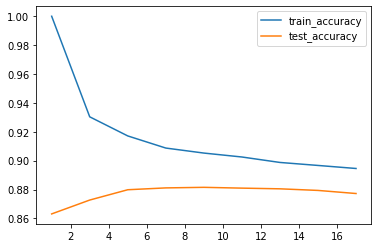

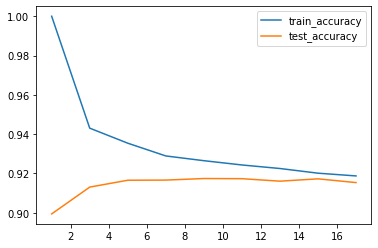

In [12]:
'''line plot-> x = k value; y = train data accuracy , test data accuracy'''
print("Line plot between traindata accuracy and test data accuracy for D1 and D2 dataframes:\n")
print(knn_accuracy_measure_D1.plot.line())
time.sleep(5)
print(knn_accuracy_measure_D2.plot.line())
